# Project 4.1 - Object Proposals for Pothole Detection

This notebook implements the object proposal extraction and evaluation pipeline for the Potholes dataset.

## Tasks:
1. Visualize dataset with ground truth bounding boxes
2. Extract object proposals using Selective Search
3. Evaluate proposals and determine optimal number
4. Prepare proposals with labels for detector training

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Local modules
from data_loader import PotholesDataset, create_train_val_split
from visualization import (
    plot_image_with_boxes, 
    plot_dataset_samples, 
    plot_proposals_and_gt,
    plot_recall_vs_proposals,
    plot_iou_distribution
)
from proposals import (
    selective_search, 
    extract_proposals_for_dataset, 
    get_proposal_statistics,
    load_proposals
)
from evaluation import (
    compute_iou,
    evaluate_proposals,
    assign_labels_to_proposals,
    prepare_training_data
)

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# Configuration
# Update this path based on your setup
# DATA_DIR = "/dtu/datasets1/02516/potholes"  # HPC path
DATA_DIR = "./potholes"  # Local path

# Check if data exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(
        f"Data directory not found: {DATA_DIR}\n"
        "Please sync the data from HPC or update the path."
    )

print(f"Using data directory: {DATA_DIR}")
print(f"Contents: {os.listdir(DATA_DIR)}")

Using data directory: ./potholes
Contents: ['.DS_Store', 'images', 'splits.json', 'annotations']


## Task 1: Familiarise with the Data

Load the dataset and visualize some examples with ground truth bounding boxes.

In [3]:
# Load the training dataset
train_dataset = PotholesDataset(DATA_DIR, split='train')
test_dataset = PotholesDataset(DATA_DIR, split='test')

print(f"Training set: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Training set: 532 images
Test set: 133 images


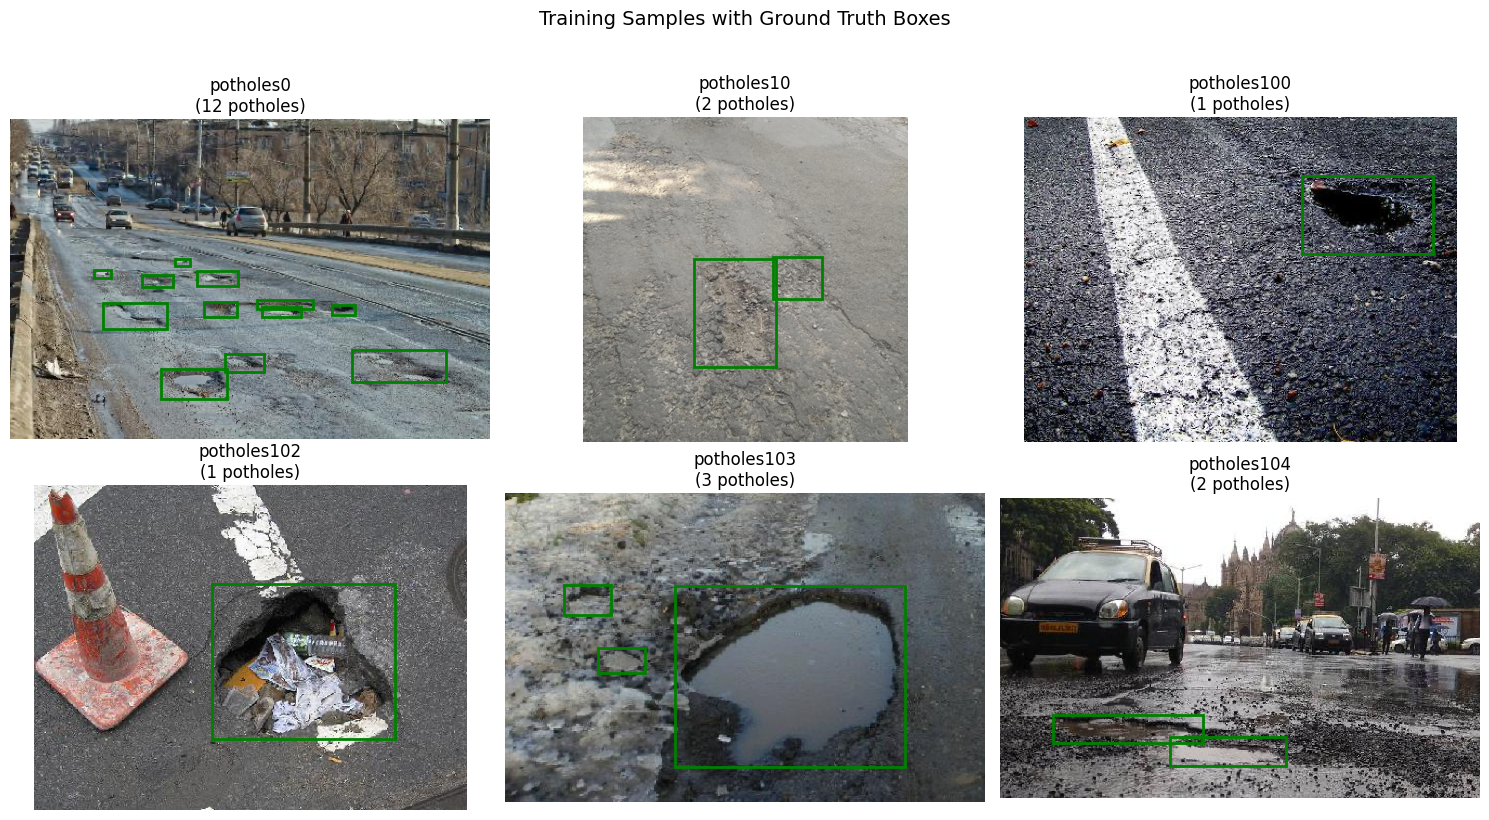

In [4]:
# Visualize some training samples
fig = plot_dataset_samples(train_dataset, num_samples=6, cols=3)
plt.suptitle("Training Samples with Ground Truth Boxes", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Boxes per image: min=1, max=19, mean=2.6
Total ground truth boxes: 1385


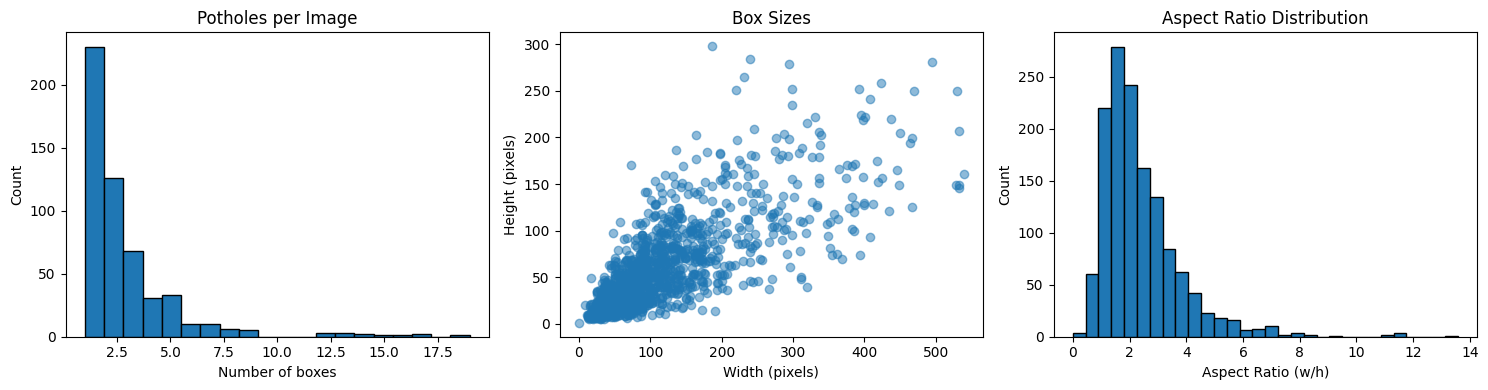

In [5]:
# Analyze dataset statistics
box_counts = []
box_sizes = []
aspect_ratios = []

for idx in range(len(train_dataset)):
    image, boxes, _ = train_dataset.get_image_and_boxes(idx)
    box_counts.append(len(boxes))
    
    for box in boxes:
        w = box[2] - box[0]
        h = box[3] - box[1]
        box_sizes.append((w, h))
        aspect_ratios.append(w / h if h > 0 else 1)

print(f"Boxes per image: min={min(box_counts)}, max={max(box_counts)}, mean={np.mean(box_counts):.1f}")
print(f"Total ground truth boxes: {sum(box_counts)}")

# Plot distribution of boxes per image
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(box_counts, bins=20, edgecolor='black')
axes[0].set_xlabel('Number of boxes')
axes[0].set_ylabel('Count')
axes[0].set_title('Potholes per Image')

widths, heights = zip(*box_sizes)
axes[1].scatter(widths, heights, alpha=0.5)
axes[1].set_xlabel('Width (pixels)')
axes[1].set_ylabel('Height (pixels)')
axes[1].set_title('Box Sizes')

axes[2].hist(aspect_ratios, bins=30, edgecolor='black')
axes[2].set_xlabel('Aspect Ratio (w/h)')
axes[2].set_ylabel('Count')
axes[2].set_title('Aspect Ratio Distribution')

plt.tight_layout()
plt.show()

## Task 2: Extract Object Proposals

Use Selective Search to extract object proposals for all images.

In [6]:
# Test Selective Search on a single image first
image, gt_boxes, image_id = train_dataset.get_image_and_boxes(0)
print(f"Image shape: {image.shape}")
print(f"Number of GT boxes: {len(gt_boxes)}")

# Run selective search
proposals = selective_search(image, mode='fast', resize_height=480)
print(f"Generated {len(proposals)} proposals")

Image shape: (300, 450, 3)
Number of GT boxes: 12
Generated 1160 proposals


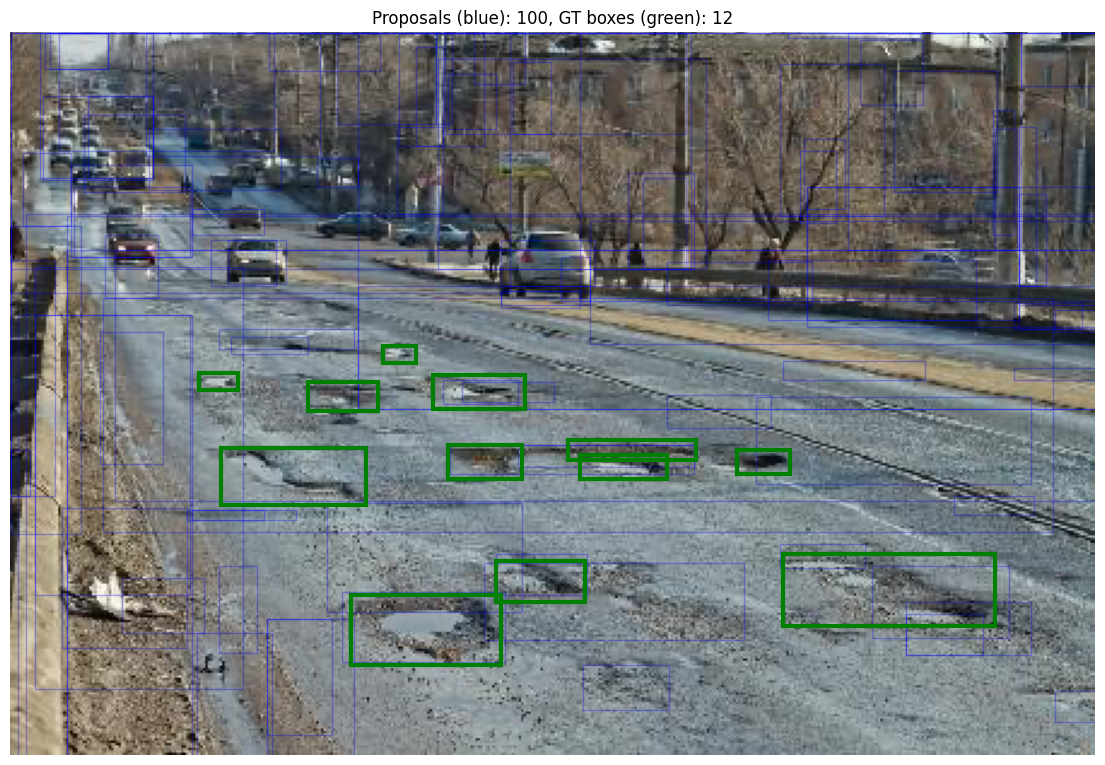

In [7]:
# Visualize proposals on the test image
fig, ax = plot_proposals_and_gt(image, proposals, gt_boxes, max_proposals=100)
plt.show()

In [8]:
# Extract proposals for all training images
# This may take several minutes

PROPOSALS_PATH = "proposals_train.npy"

if os.path.exists(PROPOSALS_PATH):
    print(f"Loading existing proposals from {PROPOSALS_PATH}")
    all_proposals = load_proposals(PROPOSALS_PATH)
else:
    print("Extracting proposals (this may take a few minutes)...")
    all_proposals = extract_proposals_for_dataset(
        train_dataset,
        mode='fast',
        resize_height=480,
        max_proposals=2000,
        save_path=PROPOSALS_PATH
    )

# Print statistics
stats = get_proposal_statistics(all_proposals)
print(f"\nProposal Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value}")

Extracting proposals (this may take a few minutes)...
Extracting proposals for 532 images...


100%|██████████| 532/532 [03:46<00:00,  2.35it/s]

Saved proposals to proposals_train.npy

Proposal Statistics:
  num_images: 532
  total_proposals: 427419
  mean_per_image: 803.4191729323309
  std_per_image: 500.31108278471174
  min_per_image: 111
  max_per_image: 2000


## Task 3: Evaluate Proposals

Evaluate the extracted proposals and determine the optimal number of proposals to use.

In [9]:
# Evaluate at different IoU thresholds
proposal_counts = [10, 20, 50, 100, 200, 500, 1000, 2000]

# Evaluate at IoU 0.5
results_05 = evaluate_proposals(
    all_proposals, 
    train_dataset, 
    proposal_counts=proposal_counts,
    iou_threshold=0.5
)

# Evaluate at IoU 0.7
results_07 = evaluate_proposals(
    all_proposals, 
    train_dataset, 
    proposal_counts=proposal_counts,
    iou_threshold=0.7
)

Evaluating proposals at IoU threshold 0.5...


100%|██████████| 532/532 [00:03<00:00, 138.24it/s]


Evaluating proposals at IoU threshold 0.7...


100%|██████████| 532/532 [00:03<00:00, 150.56it/s]


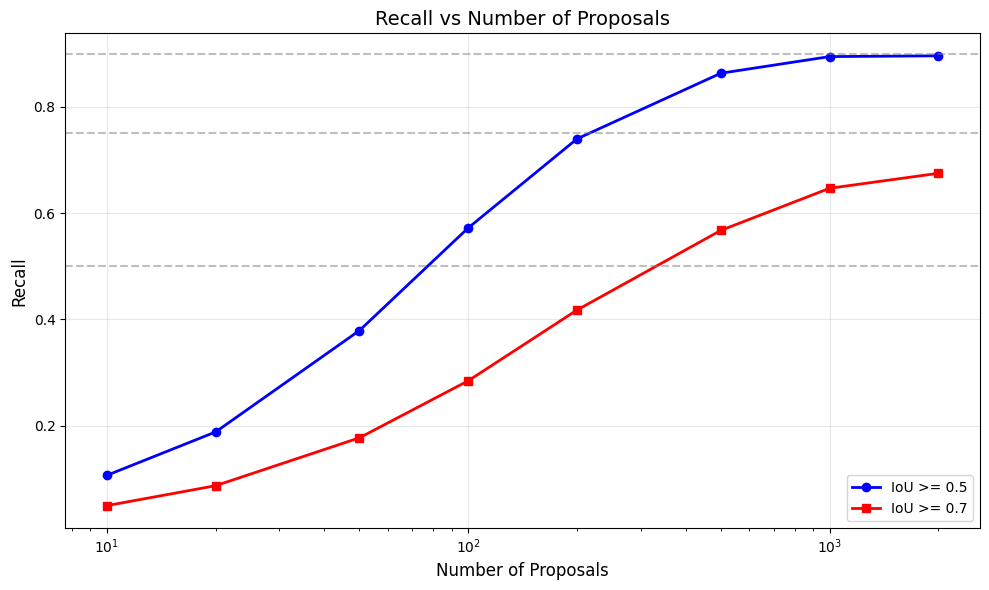


Recall at IoU=0.5:
    10 proposals: 0.107
    20 proposals: 0.188
    50 proposals: 0.379
   100 proposals: 0.572
   200 proposals: 0.740
   500 proposals: 0.863
  1000 proposals: 0.894
  2000 proposals: 0.896

Recall at IoU=0.7:
    10 proposals: 0.050
    20 proposals: 0.087
    50 proposals: 0.177
   100 proposals: 0.285
   200 proposals: 0.418
   500 proposals: 0.567
  1000 proposals: 0.647
  2000 proposals: 0.675


In [10]:
# Plot recall curves
fig, ax = plt.subplots(1, figsize=(10, 6))

ax.plot(proposal_counts, results_05['recalls'], 'b-o', label='IoU >= 0.5', linewidth=2)
ax.plot(proposal_counts, results_07['recalls'], 'r-s', label='IoU >= 0.7', linewidth=2)

ax.set_xlabel('Number of Proposals', fontsize=12)
ax.set_ylabel('Recall', fontsize=12)
ax.set_title('Recall vs Number of Proposals', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# Add horizontal lines at key thresholds
for y in [0.5, 0.75, 0.9]:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print results
print("\nRecall at IoU=0.5:")
for k, r in zip(proposal_counts, results_05['recalls']):
    print(f"  {k:4d} proposals: {r:.3f}")

print("\nRecall at IoU=0.7:")
for k, r in zip(proposal_counts, results_07['recalls']):
    print(f"  {k:4d} proposals: {r:.3f}")

In [11]:
# Determine optimal number of proposals
# Find the number where recall saturates (e.g., 90% of max recall)

max_recall = max(results_05['recalls'])
target_recall = 0.9 * max_recall

for k, r in zip(proposal_counts, results_05['recalls']):
    if r >= target_recall:
        print(f"\nRecommended number of proposals: {k}")
        print(f"  Achieves {r:.1%} recall (target was {target_recall:.1%})")
        OPTIMAL_K = k
        break
else:
    OPTIMAL_K = proposal_counts[-1]
    print(f"\nUsing maximum: {OPTIMAL_K} proposals")


Recommended number of proposals: 500
  Achieves 86.3% recall (target was 80.6%)


## Task 4: Prepare Proposals for Training

Assign labels (pothole or background) to each proposal based on IoU with ground truth.

In [12]:
# Prepare training data with labels
training_data = prepare_training_data(
    all_proposals,
    train_dataset,
    pos_iou_threshold=0.5,
    neg_iou_threshold=0.3,
    max_proposals_per_image=OPTIMAL_K
)

Preparing training data with labels...


100%|██████████| 532/532 [00:02<00:00, 223.54it/s]


Training data statistics:
  Total proposals: 229405
  Positive (pothole): 6000 (2.6%)
  Negative (background): 216527 (94.4%)
  Ignored: 6878 (3.0%)


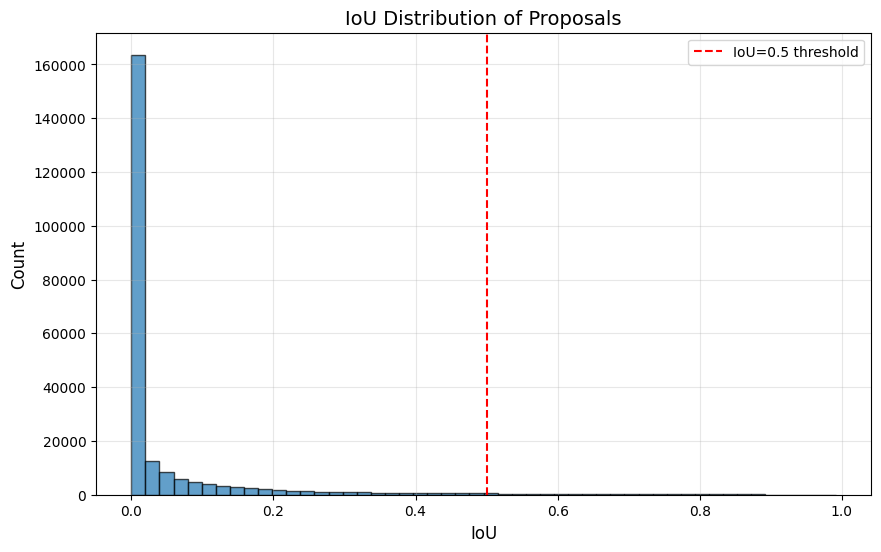

In [13]:
# Visualize IoU distribution
all_ious = []
for data in training_data.values():
    all_ious.extend(data['ious'])

fig, ax = plot_iou_distribution(all_ious, title="IoU Distribution of Proposals")
plt.show()

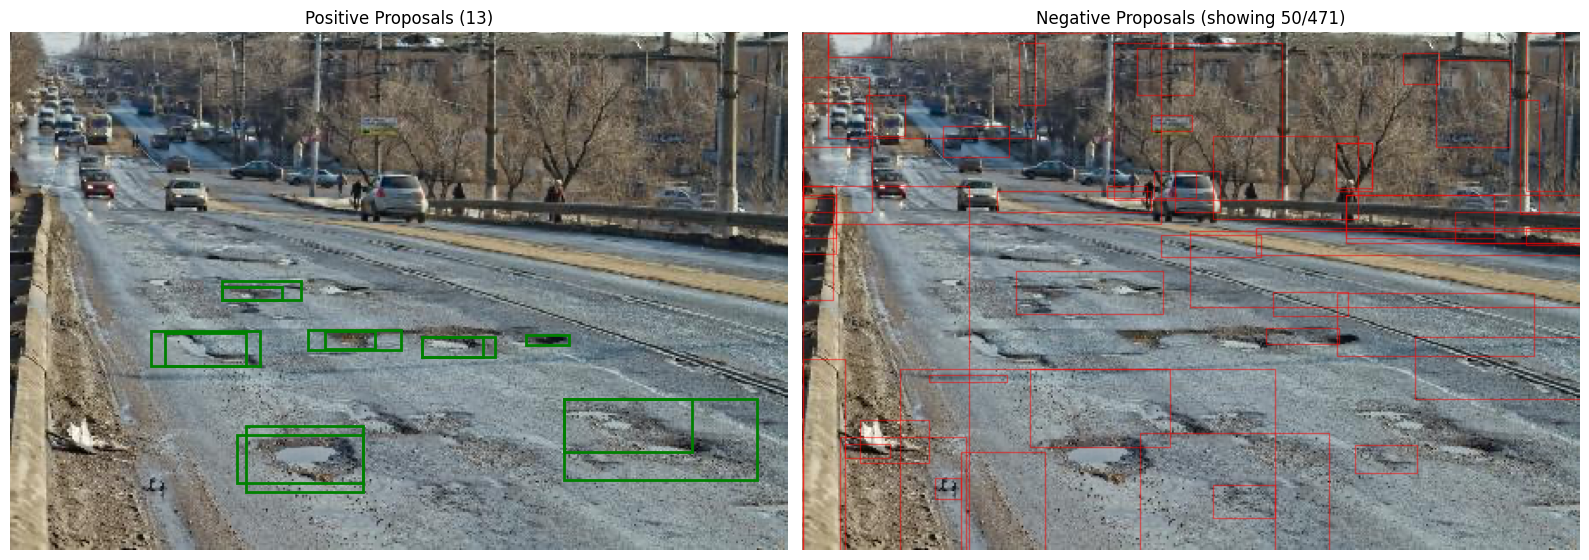

In [14]:
# Visualize positive and negative proposals for one image
sample_idx = 0
image, gt_boxes, image_id = train_dataset.get_image_and_boxes(sample_idx)

if image_id in training_data:
    data = training_data[image_id]
    
    pos_proposals = [p for p, l in zip(data['proposals'], data['labels']) if l == 1]
    neg_proposals = [p for p, l in zip(data['proposals'], data['labels']) if l == 0]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Positive proposals
    axes[0].imshow(image)
    for box in pos_proposals:
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                              fill=False, edgecolor='green', linewidth=2)
        axes[0].add_patch(rect)
    axes[0].set_title(f'Positive Proposals ({len(pos_proposals)})', fontsize=12)
    axes[0].axis('off')
    
    # Negative proposals (sample some)
    axes[1].imshow(image)
    for box in neg_proposals[:50]:  # Show first 50
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                              fill=False, edgecolor='red', linewidth=1, alpha=0.5)
        axes[1].add_patch(rect)
    axes[1].set_title(f'Negative Proposals (showing 50/{len(neg_proposals)})', fontsize=12)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [15]:
# Save the prepared training data for use in Part 4.2
np.save('training_data.npy', training_data)
print("Saved training data to training_data.npy")

Saved training data to training_data.npy


## Summary

In this notebook, we:

1. **Explored the dataset**: Visualized pothole images with ground truth bounding boxes
2. **Extracted proposals**: Used Selective Search to generate object proposals
3. **Evaluated recall**: Determined the optimal number of proposals (~X for 90% recall)
4. **Prepared training data**: Assigned positive/negative labels based on IoU

### Key Findings:
- Number of proposals needed for good recall: [FILL IN]
- Recall at IoU=0.5 with optimal K: [FILL IN]
- Positive/negative ratio: [FILL IN]

This prepared data will be used in Part 4.2 for training the object detector.